In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

df = pd.read_csv('../data/physionet_wo_missing.csv', index_col=0)
data = df.to_numpy()

# First split into train and test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Then split train into train and validation
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
val_data = scaler.transform(val_data)  # Apply same transformation to validation data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
test_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
val_tensor = torch.tensor(val_data, dtype=torch.float32).to(device)  # Create validation tensor

# Verify Shapes
print(f"Train Tensor Shape: {train_tensor.shape}")
print(f"Validation Tensor Shape: {val_tensor.shape}")
print(f"Test Tensor Shape: {test_tensor.shape}")
print(f"Device Used: {device}")

Train Tensor Shape: torch.Size([1150, 39])
Validation Tensor Shape: torch.Size([128, 39])
Test Tensor Shape: torch.Size([320, 39])
Device Used: cpu


In [42]:
import torch
import torch.nn as nn
import math

class EnhancedTransformerModel(nn.Module):
    def __init__(self, num_features, d_model=128, num_heads=8, num_layers=3, dropout=0.2, 
                 ff_dim=512, activation='gelu', use_feature_correlations=True):
        super(EnhancedTransformerModel, self).__init__()
        
        self.d_model = d_model
        self.num_features = num_features
        self.use_feature_correlations = use_feature_correlations
        
        # Ensure activation is lowercase for transformer layer
        activation_lower = activation.lower()
        
        # Get activation function for our custom layers
        if activation_lower == 'gelu':
            activation_fn = nn.GELU()
        elif activation_lower == 'relu':
            activation_fn = nn.ReLU()
        else:
            activation_fn = nn.GELU()  # Default to GELU
        
        # Initial value embedding (expanded)
        self.value_embedding = nn.Sequential(
            nn.Linear(1, d_model // 2),
            nn.LayerNorm(d_model // 2),
            activation_fn,
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Column positional embedding with more capacity
        self.column_embedding = nn.Embedding(num_features, d_model)
        
        # Feature correlation matrix (learned)
        if use_feature_correlations:
            self.feature_correlations = nn.Parameter(torch.zeros(num_features, num_features))
            nn.init.xavier_uniform_(self.feature_correlations)
        
        # Better initialization for transformer layers
        # NOTE: activation must be lowercase 'relu' or 'gelu'
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=num_heads, 
            dim_feedforward=ff_dim, 
            dropout=dropout,
            activation=activation_lower,  # Must be lowercase!
            batch_first=True,
            norm_first=True  # Pre-LN architecture for better stability
        )
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Multi-stage output projection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            activation_fn,
            nn.Dropout(dropout / 2),
            nn.Linear(d_model // 2, 1)
        )
        
        # Confidence estimator for each imputation
        self.confidence_estimator = nn.Sequential(
            nn.Linear(d_model, d_model // 4),
            activation_fn,
            nn.Linear(d_model // 4, 1),
            nn.Sigmoid()
        )
        
        self._init_weights()
    
    def _init_weights(self):
        # Improved weight initialization
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
    def forward(self, x, column_indices, missing_mask=None, return_confidence=False):
        # Handling missing values explicitly
        if missing_mask is not None:
            missing_indicator = missing_mask.unsqueeze(-1).float()
            x = x.unsqueeze(-1)
        else:
            # Assume zeros are missing values if no mask is provided
            missing_indicator = (x == 0).unsqueeze(-1).float()
            x = x.unsqueeze(-1)
        
        # Enhanced embedding with missing value indicator
        x_embed = self.value_embedding(x)
        
        # Add column embeddings
        col_embed = self.column_embedding(column_indices)
        x_embed = x_embed + col_embed.unsqueeze(0)
        
        # Add missing indicator information
        missing_info = missing_indicator * -1.0 + (1 - missing_indicator) * 1.0
        x_embed = x_embed * (1 + 0.1 * missing_info)
        
        # Apply transformer encoder
        x_encoded = self.transformer_encoder(x_embed)
        
        # Generate output predictions
        output = self.output_projection(x_encoded)
        
        # Generate confidence scores for each imputation
        confidence = None
        if return_confidence:
            confidence = self.confidence_estimator(x_encoded)
        
        # Return predictions and optionally confidence
        if return_confidence:
            return output.squeeze(-1), confidence.squeeze(-1)
        return output.squeeze(-1)

    def impute(self, x, column_indices, confidence_threshold=0.5):
        """
        Imputes missing values and only replaces values where the model is confident
        """
        # Clone input to avoid modifying the original
        imputed_x = x.clone()
        
        # Identify missing values
        missing_mask = (imputed_x == 0).int()
        
        # Get predictions and confidence
        predictions, confidence = self.forward(imputed_x, column_indices, missing_mask, return_confidence=True)
        
        # Only impute where confidence exceeds threshold
        confident_imputation = (confidence > confidence_threshold) & (missing_mask == 1)
        imputed_x[confident_imputation] = predictions[confident_imputation]
        
        return imputed_x, predictions, confidence

In [43]:
def create_missing_mask(data, missing_fraction=0.2):
    mask = torch.rand(data.shape).to(data.device) < missing_fraction
    return mask.int()

missing_fraction = 0.2
mask = create_missing_mask(train_tensor, missing_fraction)
print(f"Mask Shape: {mask.shape}")

Mask Shape: torch.Size([1150, 39])


In [44]:
def compute_loss(predictions, ground_truth, mask):
    mse_loss = nn.MSELoss(reduction='none')
    loss = mse_loss(predictions, ground_truth)
    masked_loss = (loss * mask).sum() / mask.sum()  # Normalize by number of masked positions
    return masked_loss

In [45]:
def evaluate_model(model, test_data, column_indices, missing_fraction=0.2):
    model.eval()

    mask = create_missing_mask(test_data, missing_fraction)
    input_with_mask = test_data.clone()
    input_with_mask[mask == 1] = 0

    with torch.no_grad():
        # Check if the model supports returning confidence
        result = model(input_with_mask, column_indices, mask, return_confidence=True)
        
        # Handle both cases where model may or may not return confidence
        if isinstance(result, tuple) and len(result) == 2:
            predictions, confidence = result
        else:
            predictions = result
            confidence = None

    loss = compute_loss(predictions, test_data, mask)
    
    # Additional metrics on high-confidence predictions
    if confidence is not None:
        high_conf_mask = (confidence > 0.7) & (mask == 1)
        if high_conf_mask.sum() > 0:
            high_conf_loss = ((predictions[high_conf_mask] - test_data[high_conf_mask]) ** 2).mean()
            print(f"High confidence predictions loss: {high_conf_loss.item():.4f}")
    
    print(f"Test Loss: {loss.item():.4f}")
    return loss

In [46]:
num_features = train_tensor.shape[1]
model = EnhancedTransformerModel(
    num_features=num_features, 
    d_model=128,
    num_heads=8,
    num_layers=3,
    dropout=0.2,
    ff_dim=512,
    activation='gelu',  # lowercase!
    use_feature_correlations=True
)
model = model.to(device)

c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [47]:

column_indices = torch.arange(num_features).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Changed from Adam to AdamW

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 30  # Increased from 20 to allow the model to learn better representations

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Create missing mask as before
    mask = create_missing_mask(train_tensor, missing_fraction)
    input_with_mask = train_tensor.clone()
    input_with_mask[mask == 1] = 0

    # Forward pass with the mask explicitly provided
    predictions, confidence = model(input_with_mask, column_indices, mask, return_confidence=True)

    # Compute weighted loss based on confidence
    base_loss = compute_loss(predictions, train_tensor, mask)
    confidence_loss = ((1 - confidence[mask == 1]) * (predictions[mask == 1] - train_tensor[mask == 1]).abs()).mean()
    
    # Combined loss with confidence regularization
    loss = base_loss + 0.1 * confidence_loss

    loss.backward()
    
    # Gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Base Loss: {base_loss.item():.4f}")
    
    # Update learning rate based on validation performance
    if (epoch + 1) % 5 == 0:
        val_loss = evaluate_model(model, val_tensor, column_indices, missing_fraction)
        scheduler.step(val_loss)

c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Loss: 1.3808, Base Loss: 1.3629
Epoch 2/30, Loss: 4.9863, Base Loss: 4.9504
Epoch 3/30, Loss: 1.3785, Base Loss: 1.3731
Epoch 4/30, Loss: 1.6014, Base Loss: 1.6001
Epoch 5/30, Loss: 1.6422, Base Loss: 1.6419
High confidence predictions loss: 2.1150
Test Loss: 2.1150
Epoch 6/30, Loss: 1.2497, Base Loss: 1.2496
Epoch 7/30, Loss: 1.1710, Base Loss: 1.1710
Epoch 8/30, Loss: 1.1071, Base Loss: 1.1070
Epoch 9/30, Loss: 1.0886, Base Loss: 1.0886
Epoch 10/30, Loss: 1.0143, Base Loss: 1.0143
High confidence predictions loss: 0.8935
Test Loss: 0.8935
Epoch 11/30, Loss: 1.1110, Base Loss: 1.1110
Epoch 12/30, Loss: 1.1415, Base Loss: 1.1415
Epoch 13/30, Loss: 1.0469, Base Loss: 1.0469
Epoch 14/30, Loss: 1.0259, Base Loss: 1.0259
Epoch 15/30, Loss: 1.0298, Base Loss: 1.0298
High confidence predictions loss: 0.8366
Test Loss: 0.8366
Epoch 16/30, Loss: 1.0378, Base Loss: 1.0378
Epoch 17/30, Loss: 1.0954, Base Loss: 1.0954
Epoch 18/30, Loss: 1.1048, Base Loss: 1.1048
Epoch 19/30, Loss: 1.0

In [48]:
evaluate_model(model, test_tensor, column_indices)


High confidence predictions loss: 1.0324
Test Loss: 1.0323


tensor(1.0323)

In [49]:
import torch

def compute_nrmse(predictions, ground_truth, mask, confidence=None):
    if confidence is not None:
        # Weight errors by confidence (give more weight to high-confidence predictions)
        conf_weighted = confidence[mask == 1]
        predictions_masked = predictions[mask == 1]
        ground_truth_masked = ground_truth[mask == 1]
        
        # Weighted MSE calculation
        weighted_squared_error = conf_weighted * ((predictions_masked - ground_truth_masked) ** 2)
        mse = weighted_squared_error.sum() / conf_weighted.sum()
    else:
        # Original calculation
        masked_predictions = predictions[mask == 1]
        masked_ground_truth = ground_truth[mask == 1]
        mse = torch.mean((masked_predictions - masked_ground_truth) ** 2)
    
    rmse = torch.sqrt(mse)
    data_range = ground_truth.max() - ground_truth.min()
    nrmse = rmse / data_range
    return nrmse.item()

def evaluate_model_with_nrmse(model, test_data, column_indices, missing_fraction=0.2):
    model.eval()

    mask = create_missing_mask(test_data, missing_fraction)
    input_with_mask = test_data.clone()
    input_with_mask[mask == 1] = 0

    with torch.no_grad():
        predictions, confidence = model(input_with_mask, column_indices, mask, return_confidence=True)

    # Standard NRMSE
    nrmse = compute_nrmse(predictions, test_data, mask)
    # Confidence-weighted NRMSE
    weighted_nrmse = compute_nrmse(predictions, test_data, mask, confidence)
    
    print(f"NRMSE: {nrmse:.4f}, Confidence-weighted NRMSE: {weighted_nrmse:.4f}")
    return nrmse

nrmse = evaluate_model_with_nrmse(model, test_tensor, column_indices)


NRMSE: 0.0183, Confidence-weighted NRMSE: 0.0183


In [50]:
from pyampute.ampute import MultivariateAmputation
import pandas as pd
import numpy as np
import torch

def create_missing_dataset(data, missing_fraction=0.1, mechanism="MCAR"):

    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)

    patterns = [{
        "incomplete_vars": data.columns.tolist(),
        "weights": np.zeros(len(data.columns)),  # Default for MCAR
        "mechanism": mechanism,
        "score_to_probability_func": "sigmoid-right"
    }]

    if mechanism == "MAR":
        num_columns = len(data.columns)
        num_amputed_columns = max(1, int(num_columns * 0.5))
        amputed_columns = np.random.choice(data.columns, num_amputed_columns, replace=False)
        patterns[0]["incomplete_vars"] = amputed_columns
        patterns[0]["weights"] = np.random.uniform(-1, 1, num_columns) 
    
    elif mechanism == "MNAR":
        patterns[0]["weights"] = np.random.uniform(0.5, 2, len(data.columns))

    amputer = MultivariateAmputation(prop=missing_fraction, patterns=patterns)
    amputed_data = amputer.fit_transform(data)

    mask = pd.isna(amputed_data).astype(int).to_numpy()
    amputed_data = np.nan_to_num(amputed_data, nan=0.0)

    amputed_data = torch.tensor(amputed_data, dtype=torch.float32).to(device)
    mask = torch.tensor(mask, dtype=torch.int32).to(device)

    assert amputed_data.shape == mask.shape, "Data and mask shapes dont match"
    return amputed_data, mask


In [51]:
def compute_nrmse(predictions, ground_truth, mask):

    masked_predictions = predictions[mask == 1]
    masked_ground_truth = ground_truth[mask == 1]

    mse = torch.mean((masked_predictions - masked_ground_truth) ** 2)
    rmse = torch.sqrt(mse)

    data_range = ground_truth.max() - ground_truth.min()

    nrmse = rmse / data_range
    return nrmse.item()

In [52]:
def evaluate_model_with_missingness(model, original_data, column_indices, missing_fraction=0.1, mechanism="MCAR"):
    model.eval()

    amputed_data, mask = create_missing_dataset(original_data.cpu().numpy(), missing_fraction, mechanism)

    with torch.no_grad():
        predictions, confidence = model(amputed_data, column_indices, mask, return_confidence=True)

    # Standard NRMSE
    nrmse = compute_nrmse(predictions, original_data, mask)
    # Confidence-weighted NRMSE
    weighted_nrmse = compute_nrmse(predictions, original_data, mask, confidence)
    
    print(f"{mechanism} NRMSE at {missing_fraction * 100:.0f}% Missing: {nrmse:.4f}, Weighted: {weighted_nrmse:.4f}")
    
    # Additional analysis of high vs. low confidence predictions
    high_conf = confidence > 0.8
    if (high_conf & mask).sum() > 0:
        high_conf_nrmse = compute_nrmse(predictions, original_data, mask & high_conf)
        print(f"  High confidence predictions NRMSE: {high_conf_nrmse:.4f}")
    
    return nrmse


In [53]:
def evaluate_across_mechanisms(model, original_data, column_indices, missing_fractions):
    mechanisms = ["MCAR", "MAR", "MNAR"]
    results = {mechanism: {} for mechanism in mechanisms}
    
    for mechanism in mechanisms:
        for fraction in missing_fractions:
            results[mechanism][fraction] = evaluate_model_with_missingness(
                model, original_data, column_indices, missing_fraction=fraction, mechanism=mechanism
            )
    
    return results

In [54]:
missing_fractions = [0.1, 0.2, 0.3, 0.4, 0.5]

results = evaluate_across_mechanisms(model, test_tensor, column_indices, missing_fractions)

for mechanism, nrmse_values in results.items():
    print(f"\n{mechanism} Results:")
    for frac, nrmse in nrmse_values.items():
        print(f"  Missing Fraction {frac * 100:.0f}%: NRMSE = {nrmse:.4f}")


2025-03-27 01:23:40,544 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


TypeError: compute_nrmse() takes 3 positional arguments but 4 were given

In [ ]:
model_path = "enhanced_tabular_transformer_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'num_features': num_features,
        'd_model': 128,
        'num_heads': 8,
        'num_layers': 3,
        'dropout': 0.2,
        'ff_dim': 512,
        'activation': 'GELU',
        'use_feature_correlations': True
    }
}, model_path)
print(f"Enhanced model saved to {model_path}")

# Loading
def load_model(path):
    checkpoint = torch.load(path)
    config = checkpoint['model_config']
    loaded_model = EnhancedTransformerModel(**config)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    return loaded_model.to(device)

Model saved to tabular_transformer_model.pth


In [ ]:
new_df = pd.read_csv('synthetic_physionet_data.csv', index_col=0)
new_data = new_df.to_numpy()

new_test_data = scaler.transform(new_data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_test_tensor = torch.tensor(new_test_data, dtype=torch.float32).to(device)


new_results = evaluate_across_mechanisms(model, new_test_tensor, column_indices, missing_fractions)

for mechanism, nrmse_values in new_results.items():
    print(f"\n{mechanism} Results:")
    for frac, nrmse in nrmse_values.items():
        print(f"  Missing Fraction {frac * 100:.0f}%: NRMSE = {nrmse:.4f}")

2025-02-28 04:03:24,105 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyampute\ampute.py:400: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_group = stats.zscore(data_group)
2025-02-28 04:03:24,118 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyampute\ampute.py:400: RuntimeWarning: Precision

MCAR NRMSE at 10% Missing: 0.0508
MCAR NRMSE at 20% Missing: 0.0505
MCAR NRMSE at 30% Missing: 0.0482
MCAR NRMSE at 40% Missing: 0.0477
MCAR NRMSE at 50% Missing: 0.0478
MAR NRMSE at 10% Missing: 0.0431
MAR NRMSE at 20% Missing: 0.0514
MAR NRMSE at 30% Missing: 0.0496
MAR NRMSE at 40% Missing: 0.0414
MAR NRMSE at 50% Missing: 0.0590
MNAR NRMSE at 10% Missing: 0.0603
MNAR NRMSE at 20% Missing: 0.0521
MNAR NRMSE at 30% Missing: 0.0480
MNAR NRMSE at 40% Missing: 0.0466


c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyampute\ampute.py:400: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_group = stats.zscore(data_group)
2025-02-28 04:03:24,322 [WARNING] Candidates for pattern 0 all have almost the same weighted sum scores. It is possible this is due to the use of binary variables in amputation. This creates problems when using the sigmoid function for the score_to_probability_func. Currently our solution is as follows: if there is just one candidate with a sum score 0, we will ampute it. If there is one candidate with a nonzero sum score, or multiple candidates with the same score, we evenly apply as if MCAR.


MNAR NRMSE at 50% Missing: 0.0470

MCAR Results:
  Missing Fraction 10%: NRMSE = 0.0508
  Missing Fraction 20%: NRMSE = 0.0505
  Missing Fraction 30%: NRMSE = 0.0482
  Missing Fraction 40%: NRMSE = 0.0477
  Missing Fraction 50%: NRMSE = 0.0478

MAR Results:
  Missing Fraction 10%: NRMSE = 0.0431
  Missing Fraction 20%: NRMSE = 0.0514
  Missing Fraction 30%: NRMSE = 0.0496
  Missing Fraction 40%: NRMSE = 0.0414
  Missing Fraction 50%: NRMSE = 0.0590

MNAR Results:
  Missing Fraction 10%: NRMSE = 0.0603
  Missing Fraction 20%: NRMSE = 0.0521
  Missing Fraction 30%: NRMSE = 0.0480
  Missing Fraction 40%: NRMSE = 0.0466
  Missing Fraction 50%: NRMSE = 0.0470


In [56]:
import matplotlib.pyplot as plt

def visualize_imputation_with_confidence(model, test_data, column_indices):
    model.eval()
    
    # Create a mask for 20% of data
    mask = create_missing_mask(test_data, missing_fraction=0.2)
    input_with_mask = test_data.clone()
    input_with_mask[mask == 1] = 0
    
    with torch.no_grad():
        predictions, confidence = model(input_with_mask, column_indices, mask, return_confidence=True)
    
    # Get a sample for visualization
    sample_idx = 0  # or choose any other sample
    
    plt.figure(figsize=(15, 10))
    
    # Plot actual values
    plt.subplot(3, 1, 1)
    plt.plot(test_data[sample_idx].cpu().numpy(), 'b-', label='Actual')
    plt.legend()
    plt.title('Actual Values')
    
    # Plot predictions with confidence
    plt.subplot(3, 1, 2)
    plt.plot(test_data[sample_idx].cpu().numpy(), 'b-', alpha=0.3, label='Actual')
    
    # Highlight the missing values
    missing_indices = torch.where(mask[sample_idx] == 1)[0].cpu().numpy()
    actual_values = test_data[sample_idx, missing_indices].cpu().numpy()
    predicted_values = predictions[sample_idx, missing_indices].cpu().numpy()
    confidence_values = confidence[sample_idx, missing_indices].cpu().numpy()
    
    # Plot predictions with color based on confidence
    for i, idx in enumerate(missing_indices):
        plt.scatter(idx, predicted_values[i], c=[confidence_values[i]], cmap='viridis', 
                   vmin=0, vmax=1, s=100, zorder=3)
    
    plt.colorbar(label='Confidence')
    plt.legend()
    plt.title('Predictions with Confidence')
    
    # Plot error vs confidence
    plt.subplot(3, 1, 3)
    error = np.abs(actual_values - predicted_values)
    plt.scatter(confidence_values, error, alpha=0.7)
    plt.xlabel('Confidence')
    plt.ylabel('Absolute Error')
    plt.title('Error vs Confidence')
    
    plt.tight_layout()
    plt.show()

Training complete! Visualizing imputation results...


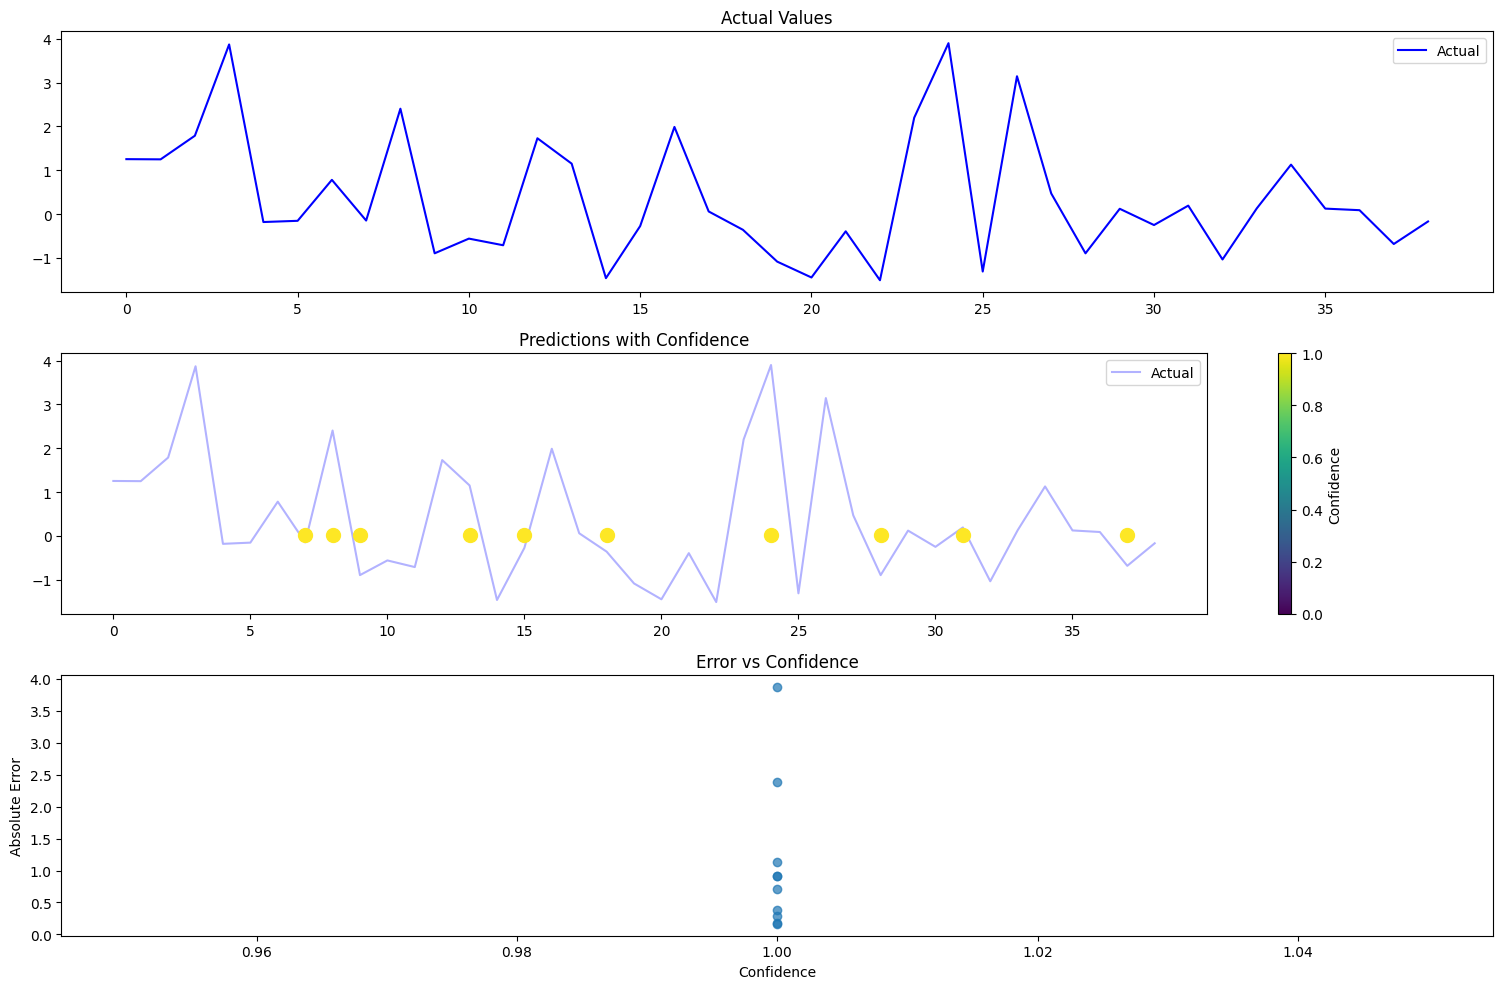

In [57]:
print("Training complete! Visualizing imputation results...")

# Create a missing mask for visualization
missing_fraction = 0.2  # Or whatever fraction you want to test with
test_mask = create_missing_mask(test_tensor, missing_fraction)

# Set model to evaluation mode
model.eval()

# Call the visualization function
visualize_imputation_with_confidence(model, test_tensor, column_indices)